# Monte Carlo simulation of X-ray imaging

The two main interaction processes between photon and matter is the photoelectric effect and Compton scattering. The photoelectric effect is a process where an electron with energy E is absorbed by an atom. The process where a photon interacts with an outer electron of an atom, leading to a change in the photons energy and direction is known as Compton scattering. When taking these two effects into account, we assume that there is a probability p of a photon being absorbed or scattered when moving a small distance x to $x+\Delta x$. (And a probability of 1-p of it moving through unhindered.)
If we assume that the intensity of a photon beam is equal to $I(x)$, the above assumption would mean that the expected intensity of the beam at $x + \Delta x$ is equal to 

$I(x+\Delta x) = I(x)(1-p) + 0*p \,\,\,\,(1)$.

The first part of this notebook will look at x-ray imaging in one direction. The space it moves through is discretized into N different sections, where each distance is given by $\Delta x$. In this project the assumption that $p = \mu \Delta x$ will be made, where $\mu$ is the so-called attenuation coefficient. The attenuation coefficient describes the extent at which the radiant flux of a beam reduces as it moves through a material.

Rearranging the terms in (1), plugging in the definition of the probability p, and considering infitesimal steps ($\Delta x \rightarrow 0$), we get the differential equation

$\frac{dI(x)}{dx} = -\mu I(x) \,\,\,\,(2)$.

This equation has the analytical solution 

$I(x) = I_0 e^{-\mu x} \,\,\,\, (3)$,

where $I_0$ is the initial intensity of the beam. This analytical solution will be used to measure how good the numerical approximation is.

For the later parts of the project, some data of attenuation coefficients will be used. These are structured in datafiles giving the attenuation coefficient of the different materials for different energies.

In [1]:
#%matplotlib notebook
# Importing necessary libraries
import numpy as np # Numpy for handling arrays
import matplotlib.pyplot as plt # Matplotlib to do the plotting
from mpl_toolkits.mplot3d import Axes3D # For 3D plots
from IPython.display import HTML, display # For tables
import tabulate # Tables
from numba import jit #just in time compilation - faster code

# Fixing some parameters for all of the figures
plt.rcParams.update({'axes.grid': True, 'grid.linestyle' : "--", 'figure.figsize' : (9.5,6)})

In [2]:
%%html 
<style>
.output_wrapper button.btn.btn-default, .output_wrapper .ui-dialog-titlebar {
    display: none;
} </style>

Above block is just to remove the interactive buttons that comes with the notebook backend to get cleaner figures.

### Part 1

In this part a one-dimensional beam of photons will be sent through a material with dampening coefficient, $\mu$.
The result from the Monte-Carlo method and the analytical solution will be compared.
In the end the stability of the Monte-Carlo method will be looked into by comparing different number of photons and different steplengths $\Delta x$. This part is mainly to check that the numerical solver corresponds with the analytical solution.

In [8]:
@jit(nopython=True) # just-in-time compilation
def simulate_photons(n_photons, n_steps, width, my):
    """
    Approximates the intensity of a photon beam moving through a material evaluated at different steps.
    The approximation is based on a Monte Carlo method using the fact that for each distance x to x + Delta x
    there is a probability p that the photon either will scatter or be absorved. This probability is equal to
    the length moved and the attenuation coefficient. A random number is sampled at each step and compared to this 
    probability to determine if the photon will keep on moving or not.

        Parameters:
            n_photons (int):        number of photons
            n_steps (int):          number of discrete steps taken through the material
            width (float):          the width of the material (cm)
            my (1D float array):    the attenuation coefficient of the material at each step
        
        Output:
            I (1D float array):     the intensity at each step relative to initial intensity

        Raise:
            ValueError if n_steps is not equal to length of my
            ValueError if n_photons is smaller than 1
            ValueError if width is negative
    """

    if n_steps != len(my):
        raise ValueError('The number of steps must be equal to the number of attenuation coefficients.')
    if n_photons < 1:
        raise ValueError('The number of photons must be positive.')
    if width <= 0:
        raise ValueError('The width must be positive.')
    
    
    dx = width / n_steps
    lengths = np.zeros(n_photons) # Each element i is the lenght (cm) photon i reached
    p = my * dx # Pobabilities of being scattered/absorbed at the different steps           
    r = np.random.rand(n_photons, n_steps) # Random numbers for comparing with p
    
    for i in range(n_photons):    
        # Simulate each photon seperately      
        length = width # If not scattered/absorbed this won't be overwritten
        for j in range(n_steps):
            # Going through each step in the material
            if r[i, j] < p[j]:
                # If true the photon was absorbed during step j
                length = dx * j # The length the photon reached
                break
        lengths[i] = length # Storing the length photon i reached
    
    I = np.zeros(n_steps + 1) # Contains the relative intensity at each gridpoint (including start/end)

    I[0] = 1 # First intensity equal to 1
    for i in range(n_steps):
        # Calculating the intensity after each step
        nFotoner_i = np.sum(lengths == dx * i) # The number of photons absorbed in this step
        I[i+1] = I[i] - nFotoner_i / n_photons # Removing the percentage of photons absorbed from intensity
    
    return I

In [9]:
# Defining some parameters for the first part
# Adding _1 to the parameters to keep them separated from the other parts
'''
- width: the width of the material (cm)
- n_steps: the number of steps
- x: the points along the x-axis
- n_photons: number of photons
- my: the attenuation coefficient of the material, cm^-1
'''

width_1 = 10
n_steps_1 = 100
x_1 = np.linspace(0, width_1, n_steps_1 + 1)
n_photons_1 = 1000
my1 = 0.1 * np.ones(n_steps_1)

In [10]:
# In both the numerical and the analytical solution, the intensity is scaled to 1

# Numerical simulation given the parameters above
I1 = simulate_photons(n_photons_1, n_steps_1, width_1, my1) 

# Analytical solution given the parameters:
I_analytical = np.exp(-my1[0] * x_1) # For this part we assume attenuation coefficient to be constant

### Figure 1: Comparison between Monte Carlo method and Analytical solution

In the figure below the accuracy of the numerical simulation is shown for different number of photons.

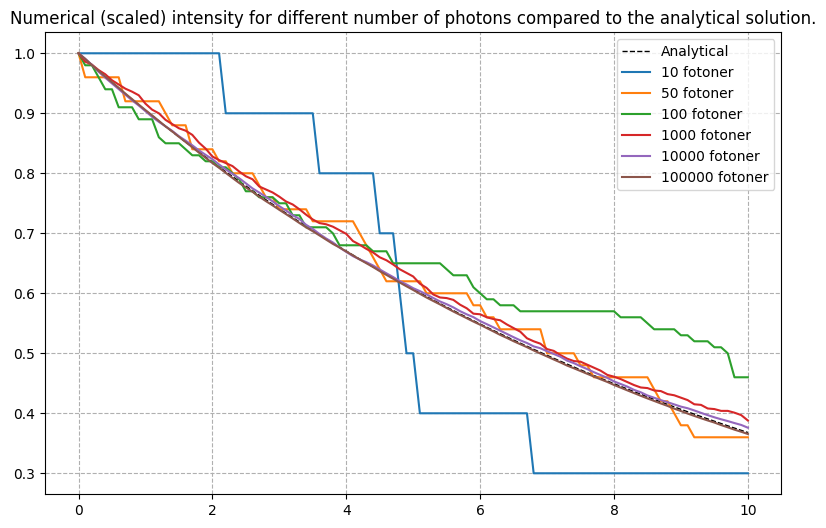

In [11]:
# Comparing the analytical solution with the numerical solution
fig1 = plt.figure()
plt.plot(x_1, I_analytical, label = 'Analytical', linestyle = '--', color = 'black', linewidth = 1)

number_of_photons = [10, 50, 100, 1000, 10000, 100000]

for i, n_photon in enumerate(number_of_photons):
    # Going through the different numbers of photons
    I_numerical = simulate_photons(n_photon, n_steps_1, width_1, my1)
    plt.plot(x_1, I_numerical, label = f"{n_photon} fotoner")
plt.title("Numerical (scaled) intensity for different number of photons compared to the analytical solution.")
plt.legend()
plt.show()

From the plot above it is clear to see that as the number of photons in the photon beam increases, the Monte Carlo approximation approaches the analytical solution. 

Now, the numerical approximation and the analytical solution will be compared more accurately. To this end the function to simulate photons will be run a thousand times for each different number of photons. Afterwards, the mean distance and standard deviation from the analytical solution calculated.

In [13]:
tabell = []
for i, n_photon in enumerate(number_of_photons):
    distance = np.zeros(n_steps_1 + 1)
    for j in range(1000):
        I = simulate_photons(n_photon, n_steps_1, width_1, my1)
        distance += abs(I_analytical - I) # Summing up the total distances of all the runs
    
    # Calculate averages and standard deviations
    mean_error = np.mean(distance/1000) 
    std_error = np.std(distance/1000)
    
    # Adding result to table for easier
    tabell.append([f"{n_photon}", round(mean_error, 4), round(std_error, 4)])
    
# Using library tabulate to get a good looking table
# Changing the html code to get a centered table
display(HTML('<table width="80%" style="margin: 0px auto;"><thead><tr><th style="text-align: center;">' 
      + tabulate.tabulate(tabell, headers=["Photons", "Mean error I/I0", "Standard deviation I/I0"], 
                               tablefmt="html")[52:-8] + "</table>"))

Photons,Mean error I/I0,Standard deviation I/I0
10,0.1083,0.0243
50,0.0486,0.0113
100,0.0347,0.008
1000,0.0107,0.0024
10000,0.0036,0.0009
100000,0.0016,0.0005


From the table above, it is clear that as the number of photons increases, the error and standard deviation decreases. The difference from 10,000 to 100,000 is not that big, but the run time is much greater. This means that it might be more efficient to use 10,000 for later simulations.

### Part 2

In this part two different photon beams will be simulated. One will go through only tissue, and the other will first go through tissue, then through bone and in the end through tissue again. Their contrast will be compared at different energy levels.

### Part 3
In this part photon beams will be sent through different 3d objects at different energies. 2d images will be created by sending the photon beams through the three different axise.